# LiNGAM
因果探索手法の１つ　　

前提条件は4つ
- DAGであること
- 誤差項は非ガウス分布であること
- 線形な構造方程式モデルを扱うこと
- 未観測な潜在共通変数が存在しないこと

分析の流れ  
1 課題の概要  
2 課題の背景にあるもの  
3 データを用いてドメイン知識と整合性を確認  
4 因果ダイアグラムを描く  
5 ドメイン知識と因果ダイアグラムの問題点。  
次やること（年収と各変数の関係に着目した論文を探す、教育と今回取り扱っていない変数との関係を調査した論文を探す、）

# import, function

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lingam
from lingam.utils import make_dot, make_prior_knowledge
import graphviz
from IPython.display import Image
import warnings 
warnings.simplefilter('ignore') #　LiNGAM学習時に出てくる警告文を消す
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from pgmpy.models import BayesianModel
from pgmpy.estimators import BicScore, PC, HillClimbSearch, ExhaustiveSearch, BicScore, K2Score
# ネットワークを描写するためのライブラリー
from pyvis import network as net
import networkx as nx

In [2]:
# birth_qrtrを数値に変換するための関数
def birth_change(x):
    if x == 'oct thru dec':
        num = 0
    elif x == 'jul thru sep':
        num = 1
    elif x == 'jan thru mar':
        num = 2
    elif x == 'apr thru jun':
        num = 3
    else:
        num = None
    return num

def race_change(x):
    '''
     ドメイン知識より、人種によって年収の中央値に大きく差があることがわかっている。
     この関数はその順序に合わせて、数値を割り振る際に利用する関数。
    '''
    if x == 'black':
        num = 0
    elif x == 'other':
        num = 1
    elif x == 'white':
        num = 2
    elif x == 'asian':
        num = 3
    else:
        num =None
    return num

def edu_change(x):
    '''
    collegeは専門大学や修士
    gradは大きな大学や院生のことか？
    '''
    if x == 'hs or lower':
        num = 0
    elif x == 'college':
        num = 1
    elif x == 'grad':
        num = 2
    else:
        num = None
    return num

def make_prior_knowledge_graph(prior_knowledge_matrix, label):
    d = graphviz.Digraph(engine='dot')

    # labels = [f'x{i}' for i in range(prior_knowledge_matrix.shape[0])]
    labels = label
    for label in labels:
        d.node(label, label)

    dirs = np.where(prior_knowledge_matrix > 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        d.edge(labels[from_], labels[to])

    dirs = np.where(prior_knowledge_matrix < 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        if to != from_:
            d.edge(labels[from_], labels[to], style='dashed')
    return d
# make_prior_knowledge_graph(prior_knowledge, dropna_df.columns.to_list()) #　因果探索する前の事前設定した因果ダイアグラムを図示する

# loading data
2020年のデータ  
元データがある場所： https://www.openintro.org/data/index.php?data=acs12  
https://www.census.gov/programs-surveys/acs/technical-documentation/code-lists.2020.html#list-tab-HEIUEV8BP30QK3REE9  
データの詳細： https://www2.census.gov/programs-surveys/acs/tech_docs/accuracy/ACS_Accuracy_of_Data_2020.pdf

In [3]:
first_df = pd.read_csv('acs12.csv')
first_df

,income,employment,hrs_work,race,age,gender,citizen,time_to_work,lang,married,edu,disability,birth_qrtr
0,60000.0,not in labor force,40.0,white,68,female,yes,NaN,english,no,college,no,jul thru sep
1,0.0,not in labor force,NaN,white,88,male,yes,NaN,english,no,hs or lower,yes,jan thru mar
2,NaN,NaN,NaN,white,12,female,yes,NaN,english,no,hs or lower,no,oct thru dec
3,0.0,not in labor force,NaN,white,17,male,yes,NaN,other,no,hs or lower,no,oct thru dec
4,0.0,not in labor force,NaN,white,77,female,yes,NaN,other,no,hs or lower,yes,jul thru sep
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,not in labor force,NaN,white,71,female,yes,NaN,english,yes,hs or lower,no,oct thru dec
1996,0.0,not in labor force,NaN,other,50,female,no,NaN,other,yes,hs or lower,no,jul thru sep
1997,70000.0,employed,40.0,asian,63,male,yes,30.0,english,no,college,no,jan thru mar
1998,105000.0,employed,50.0,asian,36,male,yes,30.0,english,yes,college,no,apr thru jun


In [4]:
first_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   income        1623 non-null   float64
 1   employment    1605 non-null   object 
 2   hrs_work      959 non-null    float64
 3   race          2000 non-null   object 
 4   age           2000 non-null   int64  
 5   gender        2000 non-null   object 
 6   citizen       2000 non-null   object 
 7   time_to_work  783 non-null    float64
 8   lang          1895 non-null   object 
 9   married       2000 non-null   object 
 10  edu           1942 non-null   object 
 11  disability    2000 non-null   object 
 12  birth_qrtr    2000 non-null   object 
dtypes: float64(3), int64(1), object(9)
memory usage: 203.2+ KB


In [5]:
first_df.isna().sum()

income           377
employment       395
hrs_work        1041
race               0
age                0
gender             0
citizen            0
time_to_work    1217
lang             105
married            0
edu               58
disability         0
birth_qrtr         0
dtype: int64

# pretreatment
2021年の人種別の年収の中央値（ダミー変数化する際の根拠に利用）：　https://www.statista.com/statistics/233324/median-household-income-in-the-united-states-by-race-or-ethnic-group/　　


In [23]:
df = first_df.copy()

# カテゴリー変数は数値化する必要がある

# raceをダミー変数化（アジアン、ホワイト、ブラック、その他）
race_dummies = pd.get_dummies(df.race, prefix='race', prefix_sep='_')
df = pd.concat([df, race_dummies], axis=1)
df = df.drop(columns='race')
# df.race = df.race.apply(race_change)

# citizenのダミー変数化。1の場合、米国市民、０はそれ以外
df['citizen'] = pd.get_dummies(df.citizen, drop_first=True)

# 1の場合male、０の場合female
df['gender'] = pd.get_dummies(df.gender, drop_first=True)

# lang(家庭内言語)。1の場合、english、0の場合その他
df.lang = df.lang.apply(lambda x: 1 if x == 'english' else 0)

# 結婚しているのなら１、それ以外は０
df.married = df.married.apply(lambda x: 1 if x == 'yes' else 0)

# 最終学歴
# edu_dum = pd.get_dummies(df.edu, prefix='edu', prefix_sep='_')
# df = pd.concat([df, edu_dum], axis=1)
# df = df.drop(columns='edu')
df.edu = df.edu.apply(edu_change)

# 障害者か否か。１の場合yes,0の場合no
df.disability = df.disability.apply(lambda x: 1 if x == 'yes' else 0)

# 就労状況。使わなくていいかもしれないカラム
# emp_dum = pd.get_dummies(df.employment, prefix='emp', prefix_sep='_')
# df = pd.concat([df, emp_dum], axis=1)
# df = df.drop(columns='employment')

# 四半期区分した誕生日を
df.birth_qrtr = df.birth_qrtr.apply(birth_change)

In [24]:
# 欠損値の削除
# timetowrok(通勤時間)以外の欠損値があるレコードを削除する、このカラムは欠損値が多すぎるので一旦外す
# dropna_df = df[df.columns[df.columns != 'time_to_work']].dropna()
dropna_df = df.dropna()
liner_df = dropna_df
dropna_df = dropna_df[dropna_df.columns[(dropna_df.columns != 'employment') & (dropna_df.columns != 'birth_qrtr')]]

In [25]:
# カラム番号とカラム名を格納した辞書を作る
df_dict = {}
for i,j in enumerate(dropna_df):
    df_dict[j] = i

In [26]:
dropna_df

,income,hrs_work,age,gender,citizen,time_to_work,lang,married,edu,disability,race_asian,race_black,race_other,race_white
5,1700.0,40.0,35,0,1,15.0,0,1,0.0,1,0,0,1,0
9,45000.0,84.0,27,1,1,40.0,1,1,0.0,0,0,0,0,1
11,8600.0,23.0,69,0,1,5.0,1,0,0.0,0,0,0,0,1
15,33500.0,55.0,52,1,1,20.0,1,1,0.0,0,0,0,0,1
16,4000.0,8.0,67,0,1,10.0,1,1,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988,33300.0,40.0,54,0,1,10.0,1,1,0.0,1,0,0,0,1
1992,85000.0,40.0,52,1,1,8.0,1,1,1.0,0,0,0,0,1
1994,65000.0,48.0,53,1,1,45.0,1,1,0.0,1,0,0,0,1
1997,70000.0,40.0,63,1,1,30.0,1,0,1.0,0,1,0,0,0


# LiNGAM

In [10]:
df_dict = {}
for i,j in enumerate(dropna_df):
    df_dict[j] = i
    
# 事前設定
prior_knowledge = make_prior_knowledge(
    len(df_dict), # 変数の数

    # 因果の上流にあり、他から影響を受けない変数を設定する
    exogenous_variables = [df_dict["age"], df_dict['gender'], df_dict['disability'],
                           df_dict['race_asian'], df_dict['race_black'], 
                           df_dict['race_other'], df_dict['race_white']],

    # 因果の中間地点、または因果の最終地点にある変数を設定する
    sink_variables = [df_dict['income']],

    # 有向パスを持つ変数。因果関係がある変数の組みを設定する。左側が元、右側が先。
    paths = [], # なぜか有効にならない

    # 有向パスのない変数。どことも関係のない変数を設定する場所。
    no_paths = [],                           
)

prior_knowledge[df_dict['edu_college']][df_dict['edu_grad']] = 0
prior_knowledge[df_dict['edu_grad']][df_dict['edu_college']] = 0
prior_knowledge[df_dict['edu_college']][df_dict['edu_hs or lower']] = 0
prior_knowledge[df_dict['edu_hs or lower']][df_dict['edu_college']] = 0
prior_knowledge[df_dict['edu_hs or lower']][df_dict['edu_grad']] = 0
prior_knowledge[df_dict['edu_grad']][df_dict['edu_hs or lower']] = 0

In [11]:
# LiNGAMの学習
model = lingam.DirectLiNGAM(random_state=0,
                            prior_knowledge = prior_knowledge
                            )

# sc = StandardScaler()
# sc_dropna_df = sc.fit_transform(dropna_df)
model.fit(dropna_df)

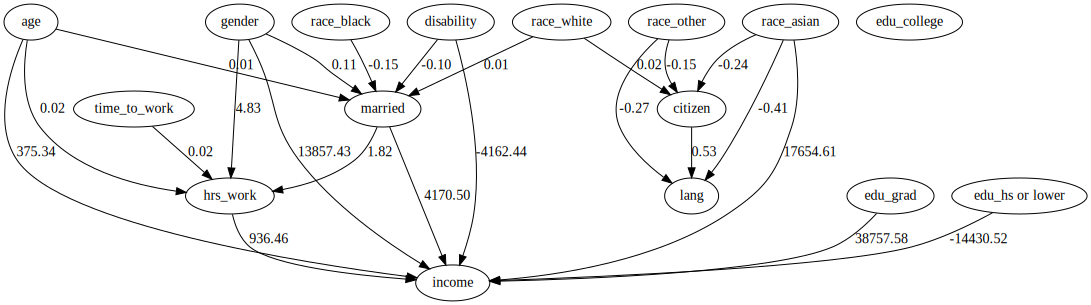

In [13]:
# 因果ダイアグラムを図示
dot = make_dot(model.adjacency_matrix_,
               labels=dropna_df.columns.to_list(),
               )

# Save png
dot.format = 'png'
dot.render('dag2')

dot

In [169]:
dropna_df.shape[0]

783

# LiNGAM with prediction model

In [43]:
# 外れ値の確認

# hrs_workが９０以上の値は削除
# liner_df = liner_df.query(' hrs_work < 90')
# sns.scatterplot(data = liner_df, y = liner_df.income, x = liner_df.hrs_work)

# 通勤時間が１５０分以上は削除
# liner_df = liner_df.query('time_to_work < 150')
# sns.scatterplot(data = liner_df, y = np.log(liner_df.income), x = 'age')

In [44]:
# 重回帰モデルを利用する
col = ['age', 'gender', 'hrs_work', 'married', 'disability', 'race_asian',  'edu',]
# col = dropna_df.drop(columns='income').columns

x = dropna_df[col]
y = dropna_df['income']

ols = sm.OLS(y, x).fit()
sk_ols = LinearRegression().fit(x,y)

print(ols.summary2())

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.534     
Dependent Variable:     income           AIC:                         19180.4786
Date:                   2023-02-27 16:08 BIC:                         19213.1206
No. Observations:       783              Log-Likelihood:              -9583.2   
Df Model:               7                F-statistic:                 129.0     
Df Residuals:           776              Prob (F-statistic):          1.74e-125 
R-squared (uncentered): 0.538            Scale:                       2.5246e+09
----------------------------------------------------------------------------------
                Coef.       Std.Err.      t      P>|t|       [0.025       0.975]  
----------------------------------------------------------------------------------
age              68.9476    109.1447    0.6317   0.5278     -145.3062     283.2014
gender        16305.3560   3788.7298    4.303

In [45]:
sk_ols.coef_, sk_ols.feature_names_in_

(array([   588.98619041,  18325.17792119,   1037.86555976,   6343.38072634,
        -14955.77976248,  28764.78820506,  26381.9618689 ]),
 array(['age', 'gender', 'hrs_work', 'married', 'disability', 'race_asian',
        'edu'], dtype=object))

In [46]:
# カラム番号とカラム名を格納した辞書を作る
df_dict = {}
for i,j in enumerate(dropna_df.drop(columns='income')):
    df_dict[j] = i

# 事前設定
prior_knowledge = make_prior_knowledge(
    len(df_dict), # 変数の数

    # 因果の上流にあり、他から影響を受けない変数を設定する
    exogenous_variables = [df_dict["age"], df_dict['gender'], df_dict['disability'],
                           df_dict['race_asian'], df_dict['race_black'], 
                           df_dict['race_other'], df_dict['race_white']],

    # 因果の中間地点、または因果の最終地点にある変数を設定する
    sink_variables = [],

    # 有向パスを持つ変数。因果関係がある変数の組みを設定する。左側が元、右側が先。
    paths = [],

    # 有向パスのない変数。どことも関係のない変数を設定する場所。
    no_paths = [],                  
)

In [47]:
model = lingam.DirectLiNGAM(random_state=0,
                            prior_knowledge = prior_knowledge)

model.fit(dropna_df.drop(columns='income'))

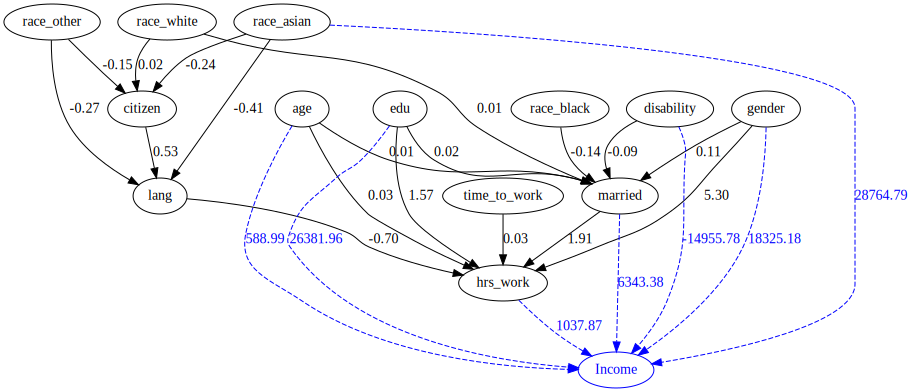

In [48]:
# features = [i for i in range(dropna_df.drop(["income"], axis=1).shape[1])]
features = [df_dict[i] for i in sk_ols.feature_names_in_]

make_dot(model.adjacency_matrix_,
         labels=dropna_df.drop(columns='income').columns.to_list(),
         prediction_feature_indices=features,
         prediction_target_label='Income',
         prediction_line_color='#0000FF',
         prediction_coefs=sk_ols.coef_)

In [49]:
# モデルの妥当性（つまり、モデルを利用するにあたって前提とした仮定が正しいかどうか）の評価
# ガウス性の検定＝観測変数や外生変数（誤差）の非ガウス性のチェック
# 外生変数（誤差）間の独立性の検定＝従属ならば潜在共通変数あり
# 全体的な適合度＝かい２乗検定

# memo
参考にしたサイト  
https://zenn.dev/megane_otoko/articles/072_casual_resoning_by_lignam  
https://lingam.readthedocs.io/en/latest/tutorial/draw_graph.html  
https://www.openintro.org/data/index.php?data=acs12  
https://www.census.gov/programs-surveys/acs/technical-documentation/code-lists.2020.html#list-tab-HEIUEV8BP30QK3REE9  
https://qiita.com/kirikei/items/3a47aecc317d6a580fbf  
https://techblog.cccmk.co.jp/entry/2022/03/22/102151  
https://vigne-cla.com/24-1/
https://www.slideshare.net/sshimizu2006/ss-60015497

# BottomUpParceLiNGAM
外生変数を考慮したLiNGAM

In [50]:
# カラム番号とカラム名を格納した辞書を作る
df_dict = {}
for i,j in enumerate(dropna_df):
    df_dict[j] = i

# 事前設定
prior_knowledge = make_prior_knowledge(
    n_variables=len(df_dict), # 変数の数

    # 因果の上流にあり、他から影響を受けない変数を設定する
    exogenous_variables = [df_dict["age"], df_dict['gender'], df_dict['disability'],
                           df_dict['race_asian'], df_dict['race_black'], 
                           df_dict['race_other'], df_dict['race_white']],

    # 因果の中間地点、または因果の最終地点にある変数を設定する
    sink_variables = [df_dict['income']],

    # 有向パスを持つ変数。因果関係がある変数の組みを設定する。左側が元、右側が先。
    paths = [[df_dict["income"], df_dict["gender"]],[df_dict['income'], df_dict['age']],],

    # 有向パスのない変数。どことも関係のない変数を設定する場所。
    no_paths = [],                           
)

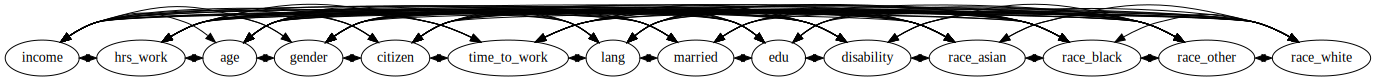

In [51]:
bup_model = lingam.BottomUpParceLiNGAM(prior_knowledge = prior_knowledge)

bup_model.fit(dropna_df)
make_dot(bup_model.adjacency_matrix_,
         labels=dropna_df.columns.to_list(),)

In [52]:
# 見ずらいので数字で表示
# 全ての変数に対して、未観測の潜在共通因子があることがわかる
print(bup_model.causal_order_)
print(bup_model.adjacency_matrix_)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]]
[[ 0. nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan  0. nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan  0. nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan  0. nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan  0. nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan  0. nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan  0. nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan  0. nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan  0. nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan  0. nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan  0. nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan  0. nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan  0. nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan  0.]]


# CAM＿UV
未観測の外生変数を考慮したモデル  
非線形の関係も考慮できる  
欠点として、計算量が多いこととデータの解釈が難しい

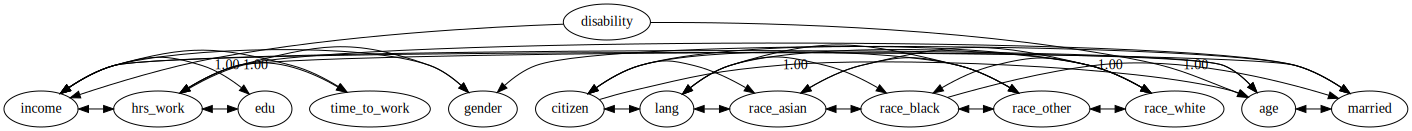

In [53]:
cam_model = lingam.CAMUV()
cam_model.fit(dropna_df)
make_dot(cam_model.adjacency_matrix_,
        labels=dropna_df.columns.to_list())

In [54]:
print(cam_model.adjacency_matrix_)
print(df_dict.keys())

[[ 0. nan nan nan  0. nan  0. nan nan  1.  0.  0.  0.  0.]
 [nan  0. nan nan  0.  0.  0. nan nan  0.  0.  0.  0.  0.]
 [nan nan  0.  0.  1.  0.  0. nan  0.  1.  0.  0.  0.  0.]
 [nan nan  0.  0.  0.  0.  0. nan  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. nan  0.  0.  0. nan  0. nan nan]
 [nan  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. nan  0.  0.  0.  0.  0. nan nan nan nan]
 [nan nan nan nan  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [nan nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. nan  0. nan  0.  0.  0.  0. nan nan nan]
 [ 0.  0.  0.  0.  0.  0. nan  0.  0.  0. nan  0. nan nan]
 [ 0.  0.  0.  0. nan  0. nan  0.  0.  0. nan nan  0. nan]
 [ 0.  0.  0.  0. nan  0. nan  0.  0.  0. nan nan nan  0.]]
dict_keys(['income', 'hrs_work', 'age', 'gender', 'citizen', 'time_to_work', 'lang', 'married', 'edu', 'disability', 'race_asian', 'race_black', 'race_other', 'race_white'])

In [55]:
# incomeと関係のある変数を洗い出し
# race_asianが消えている。よく考えればアジア人は専門職が多く、専門職だと給与が高いという因果関係かもしれず、単にアジア人ゆえにということではないのかもしれない。
for i in np.where(cam_model.adjacency_matrix_[0,:] != 0)[0]:
    print(list(df_dict.keys())[i])

hrs_work
age
gender
time_to_work
married
edu
disability


# Bayesian Network
仕組みStep３つ
- 各変数で独立性の検証をし、スケルトンを構築
- V-structure,オリエンテーションルールにより一部のスケルトンに方向を付与
- それでも方向が不明な場合、BICの値が小さいモデルを総当たりで構築

In [56]:
# ベイジアンネットワークでは独立性の検定を利用するので、ビニングする
bins_df = dropna_df.copy()
bins_df['income'] = pd.cut(dropna_df['income'],10)
bins_df['hrs_work'] = pd.cut(dropna_df.hrs_work, 10)
bins_df['age'] = pd.cut(dropna_df.age, 15)
bins_df['time_to_work'] = pd.cut(dropna_df.time_to_work, 5)

In [57]:
# 離散値にしてベイジアンネットワークを適用する場合
# pc = PC(bins_df.astype('str'))
# model = pc.estimate(significance_level=0.05)

# 連続値データセットに対してベイジアンネットワークを活用する場合
# pea_pc = PC(dropna_df)
# model = pea_pc.estimate(significance_level=0.05, ci_test='pearsonr')

# 利用するあるゴアリズムを変更。変数を選択し、その隣にあるもの同士で比較するのを繰り返すアルゴ。計算量は少ない。
model = HillClimbSearch(dropna_df).estimate(scoring_method=K2Score(dropna_df)) # 誤差の計算方法を変更

# 全組み合わせを探索するモデル。計算量が莫大になる。利用しない。
# model = ExhaustiveSearch(dropna_df).estimate()

# エッジとノードを生成
edges = model.edges()
nodes = model.nodes()

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [58]:
print(edges, nodes)

[('hrs_work', 'gender'), ('gender', 'married'), ('citizen', 'lang'), ('citizen', 'edu'), ('lang', 'race_asian'), ('lang', 'race_other'), ('married', 'age'), ('married', 'race_black'), ('disability', 'age'), ('race_asian', 'race_white'), ('race_asian', 'race_other'), ('race_asian', 'gender'), ('race_asian', 'edu'), ('race_black', 'race_white'), ('race_other', 'race_white')] ['income', 'hrs_work', 'age', 'gender', 'citizen', 'time_to_work', 'lang', 'married', 'edu', 'disability', 'race_asian', 'race_black', 'race_other', 'race_white']


In [59]:
edge_list = list(model.edges())
# edge_list = [i + tuple([0]) for i in edge_list] #ウェイトの値を適当に追加

#jupyter中に表示させる場合、notebook=True, →にする場合directed=True
got_net = net.Network(notebook=True,directed=True)

for e in edge_list:
    src = e[0]
    dst = e[1]
    # w = e[2]

    got_net.add_node(src, src, title=src)
    got_net.add_node(dst, dst, title=dst)
    got_net.add_edge(src, dst, ) # 矢印にウェイトをつける場合は引数にvalue = w を追加

neighbor_map = got_net.get_adj_list()

for node in got_net.nodes:
    node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
    node['value'] = len(neighbor_map[node['id']])
    
got_net.show_buttons(True)

got_net.show('gameofthrones.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [60]:
# CPDを求める
model = BayesianModel(list(edges))
model.add_nodes_from(list(nodes))
for edge in edges:
    model.add_edge(edge[0], edge[1])
model.fit(dropna_df)
cpds = model.get_cpds()
for cpd in cpds:
    print(cpd, '\n')

+----------------+------------+
| hrs_work(1.0)  | 0.00127714 |
+----------------+------------+
| hrs_work(4.0)  | 0.00127714 |
+----------------+------------+
| hrs_work(5.0)  | 0.00510856 |
+----------------+------------+
| hrs_work(6.0)  | 0.00510856 |
+----------------+------------+
| hrs_work(7.0)  | 0.00127714 |
+----------------+------------+
| hrs_work(8.0)  | 0.0102171  |
+----------------+------------+
| hrs_work(9.0)  | 0.00383142 |
+----------------+------------+
| hrs_work(10.0) | 0.00893997 |
+----------------+------------+
| hrs_work(11.0) | 0.00255428 |
+----------------+------------+
| hrs_work(12.0) | 0.00383142 |
+----------------+------------+
| hrs_work(13.0) | 0.00127714 |
+----------------+------------+
| hrs_work(15.0) | 0.0178799  |
+----------------+------------+
| hrs_work(16.0) | 0.00255428 |
+----------------+------------+
| hrs_work(17.0) | 0.00127714 |
+----------------+------------+
| hrs_work(18.0) | 0.00383142 |
+----------------+------------+
| hrs_wo

# 学歴とアジア系についての収入に与える交互作用を検証。

In [14]:
from statsmodels.graphics.factorplots import interaction_plot # 交差項検証用のグラフ

In [22]:
df

,income,employment,hrs_work,age,gender,citizen,time_to_work,lang,married,disability,birth_qrtr,race_asian,race_black,race_other,race_white,edu_college,edu_grad,edu_hs or lower
0,60000.0,not in labor force,40.0,68,0,1,NaN,1,0,0,1,0,0,0,1,1,0,0
1,0.0,not in labor force,NaN,88,1,1,NaN,1,0,1,2,0,0,0,1,0,0,1
2,NaN,NaN,NaN,12,0,1,NaN,1,0,0,0,0,0,0,1,0,0,1
3,0.0,not in labor force,NaN,17,1,1,NaN,0,0,0,0,0,0,0,1,0,0,1
4,0.0,not in labor force,NaN,77,0,1,NaN,0,0,1,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,not in labor force,NaN,71,0,1,NaN,1,1,0,0,0,0,0,1,0,0,1
1996,0.0,not in labor force,NaN,50,0,0,NaN,0,1,0,1,0,0,1,0,0,0,1
1997,70000.0,employed,40.0,63,1,1,30.0,1,0,0,2,1,0,0,0,1,0,0
1998,105000.0,employed,50.0,36,1,1,30.0,1,1,0,3,1,0,0,0,1,0,0


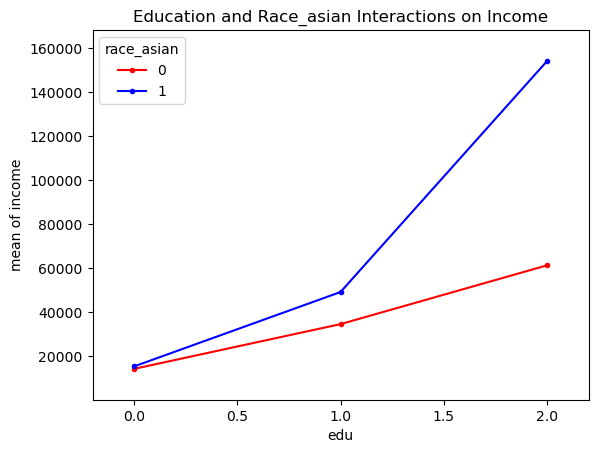

In [29]:
# 交互作用の確認
fig = interaction_plot(df.edu, df.race_asian, df.income,colors=['red', 'blue'])
plt.title('Education and Race_asian Interactions on Income')
plt.savefig('ERII.png')

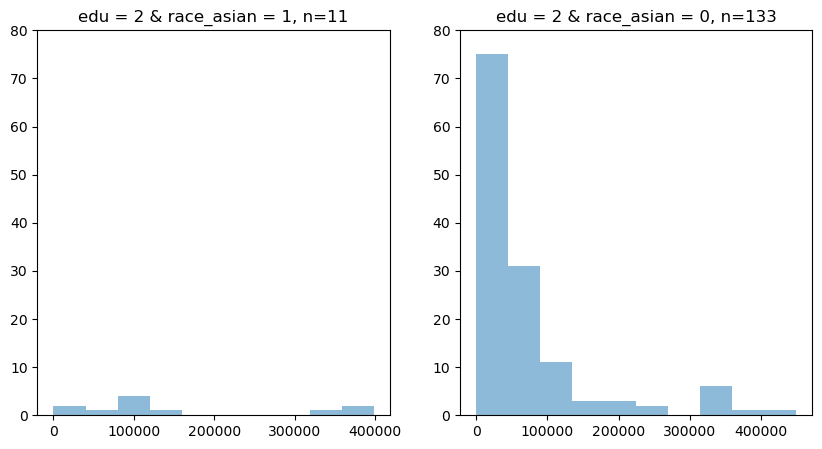

In [30]:
n1 = df.query('race_asian == 1 & edu == 2').shape[0]
n2 = df.query('race_asian == 0 & edu == 2').shape[0]

plt.figure(figsize=(10,5))
plt.title('income of edu=2')
plt.subplot(1,2,1)
plt.title(f'edu = 2 & race_asian = 1, n={n1}')
plt.hist(df.query('race_asian == 1 & edu == 2').income, alpha=0.5)
plt.ylim(0,80)
plt.subplot(1,2,2)
plt.title(f'edu = 2 & race_asian = 0, n={n2}')
plt.hist(df.query('race_asian == 0 & edu == 2').income, alpha=0.5)
plt.ylim(0,80)

plt.savefig('e=2rhist.png')
plt.show()